# Sports News Classification

## Import Libraries

In [96]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

# Define global font for EDA
font = {'family' : 'calibri',
        'weight' : 'normal',
        'size'   : 18}

## Web Scrape Data 

In [2]:
def bbc_sport_news(url):
    
    headlines_list = []
    source_list = [] 
    
    for url in url_list:
   
        data = requests.get(url)
        soup = BeautifulSoup(data.content, 'html.parser')    
        news_items = soup.find_all('div', class_="gs-c-promo")

        # Grab headlines and label sport
        sport = (url.split('/')[-1])
        for headline in news_items:
            headlines_list.append(headline["data-bbc-title"])
            source_list.append(sport)

        # Combine headline and type of sport
        dataset = pd.DataFrame(zip(headlines_list,source_list))
        dataset.columns = ['Headline', 'Sport']
        
    return dataset

In [3]:
url_list = ['https://www.bbc.co.uk/sport/football',
            'https://www.bbc.co.uk/sport/formula1',
            'https://www.bbc.co.uk/sport/cricket',
            'https://www.bbc.co.uk/sport/tennis',]
       

bbc_dataset = bbc_sport_news(url_list)

In [4]:
bbc_dataset.shape

(215, 2)

In [5]:
def sky_sports_news(url_list):    
    headlines_list = []
    source_list = []     
    for url in url_list:    
        data = requests.get(url)
        soup = BeautifulSoup(data.content, 'html.parser')    
        news_items = soup.find_all('div', class_="news-list__body")
        # Grab headlines        
        sport = (url.split('/')[-1])    
        for headline in news_items:
            headlines_list.append(headline.p.get_text())
            source_list.append(sport)               
        # Combine headline and type of sport
        dataset = pd.DataFrame(zip(headlines_list, source_list))
        dataset.columns = ['Headline', 'Sport']    
    return dataset 

In [6]:
url_list = ['https://www.skysports.com/football',
            'https://www.skysports.com/f1',
            'https://www.skysports.com/cricket',
            'https://www.skysports.com/tennis',]
       

skysports_dataset = sky_sports_news(url_list)

In [7]:
skysports_dataset.shape

(27, 2)

In [8]:
# Merge BBC and Sky Data

dataset_combined = pd.concat([bbc_dataset,skysports_dataset])

In [32]:
dataset_combined

,Headline,Sport
0,Wolves out of Europa League & transfers latest,football
1,Lewandowski's time? Man City a new winner? The...,football
2,Champions League last eight: All you need to k...,football
3,Unnamed Barcelona squad member tests positive ...,football
4,'We need more players to help our small squad'...,football
...,...,...
22,This summer's women's domestic 50-over competi...,cricket
23,Johanna Konta says she will be doing her best ...,tennis
24,Grigor Dimitrov says it has been an eye-openin...,tennis
25,Serena Williams remains committed to playing t...,tennis


In [33]:
# Save to csv
dataset_combined.to_csv('Sports_News_12thAugust.csv', index= False)

In [41]:
dataset = pd.read_csv('Sports_News_12thAugust.csv')

In [42]:
dataset

,Headline,Sport
0,Wolves out of Europa League & transfers latest,football
1,Lewandowski's time? Man City a new winner? The...,football
2,Champions League last eight: All you need to k...,football
3,Unnamed Barcelona squad member tests positive ...,football
4,'We need more players to help our small squad'...,football
...,...,...
237,This summer's women's domestic 50-over competi...,cricket
238,Johanna Konta says she will be doing her best ...,tennis
239,Grigor Dimitrov says it has been an eye-openin...,tennis
240,Serena Williams remains committed to playing t...,tennis


## Data Pre-processing

In [43]:
dataset.describe() # 5 classes

,Headline,Sport
count,242,242
unique,214,5
top,Live cricket coverage on the BBC,football
freq,2,78


In [44]:
# Check classes
dataset['Sport'].unique().tolist()

['football', 'formula1', 'cricket', 'tennis', 'f1']

In [45]:
# Change formula1 to f1 as same class
dataset['Sport'] = dataset['Sport'].replace(['formula1'],'f1')
dataset['Sport'].unique().tolist()

['football', 'f1', 'cricket', 'tennis']

In [46]:
dataset.shape

(242, 2)

## Exploratory Data Analysis

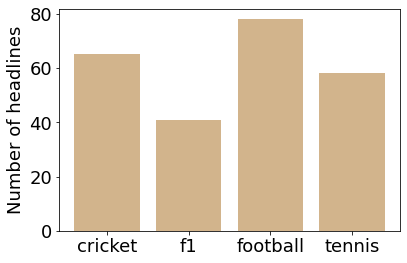

In [49]:
count = dataset.groupby(['Sport']).count()
count = count.iloc[:,0]
sport = ('cricket','f1','football','tennis')

plt.bar(sport, count, color = 'tan')
plt.ylabel('Number of headlines')
mpl.rc('font', **font)
plt.tight_layout()
plt.savefig('01_EDA_Headline_Categories.png')
plt.show()

## Data Preparation

In [52]:
X = dataset.iloc[:,0] # extract column with headlines
y = dataset.iloc[:,-1] # extract column with labels

In [53]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
X_vec = vectorizer.fit_transform(X)
X_vec.todense() # convert sparse matrix into dense matrix

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [54]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer()
X_tfidf = tfidf.fit_transform(X_vec)
X_tfidf = X_tfidf.todense()

In [55]:
X_tfidf

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [56]:
# Split dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size = 0.30, random_state = 0)

## Modelling

In [59]:
LR_model = LogisticRegression(random_state=0, multi_class = 'multinomial',
                          max_iter = 100, class_weight = 'balanced').fit(X_train, y_train)

In [60]:
SVM_model = LinearSVC()

In [69]:
RF_model = RandomForestClassifier(n_estimators=100, random_state=0)

In [62]:
NB = MultinomialNB()

/home/aiden/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Logistic Reg (baseline): 0.857721 (0.084544)
SVM: 0.828309 (0.085181)


/home/aiden/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
/home/aiden/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


Random Forest: 0.738603 (0.121762)
Naive Bayes: 0.704044 (0.091296)


/home/aiden/.local/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


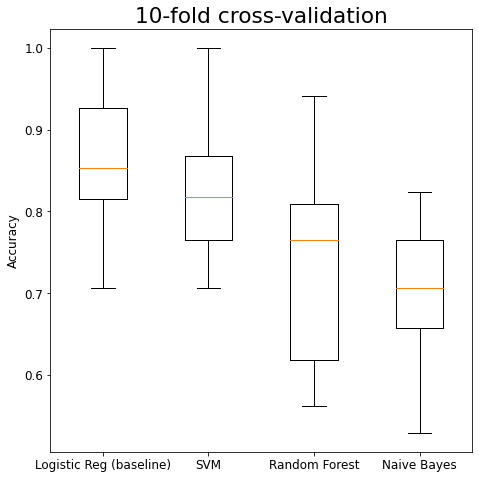

In [77]:
# List models to run CV
models = []
models.append(('Logistic Reg (baseline)', LR_model ))
models.append(('SVM', SVM_model ))
models.append(('Random Forest', RF_model ))
models.append(('Naive Bayes', NB ))


# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

plt.figure(figsize=(7,7))
plt.xticks(fontsize=12)
plt.yticks(fontsize = 12)
plt.boxplot(results, labels=names)
plt.ylabel('Accuracy', fontsize = 12)
plt.title('10-fold cross-validation')
plt.tight_layout()
mpl.rc('font', **font)
plt.savefig('02_CV_Models.png')
plt.show()


## Evaluation

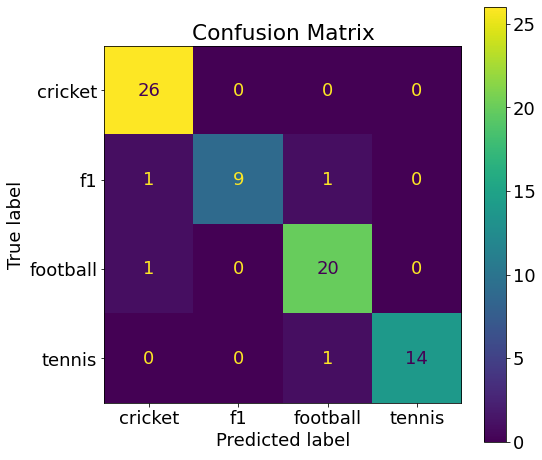

<Figure size 1440x1440 with 0 Axes>

In [95]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8,8))
disp = plot_confusion_matrix(LR_model, X_test, y_test, ax=ax)
plt.figure(figsize=(20,20))
disp.ax_.set_title('Confusion Matrix')
fig.savefig('03_Confusion_Matrix.png')
plt.show()

In [97]:
y_pred = LR_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

     cricket       0.93      1.00      0.96        26
          f1       1.00      0.82      0.90        11
    football       0.91      0.95      0.93        21
      tennis       1.00      0.93      0.97        15

    accuracy                           0.95        73
   macro avg       0.96      0.93      0.94        73
weighted avg       0.95      0.95      0.94        73

